In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Utilities

In [2]:
def show(image, title, cmap=None):
    f, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
    ax1.imshow(image, cmap=cmap)
    ax1.set_title(title, fontsize=18)
    plt.show()

In [3]:
def load_data(filepath):
    return glob.glob(filepath)

### Load Data

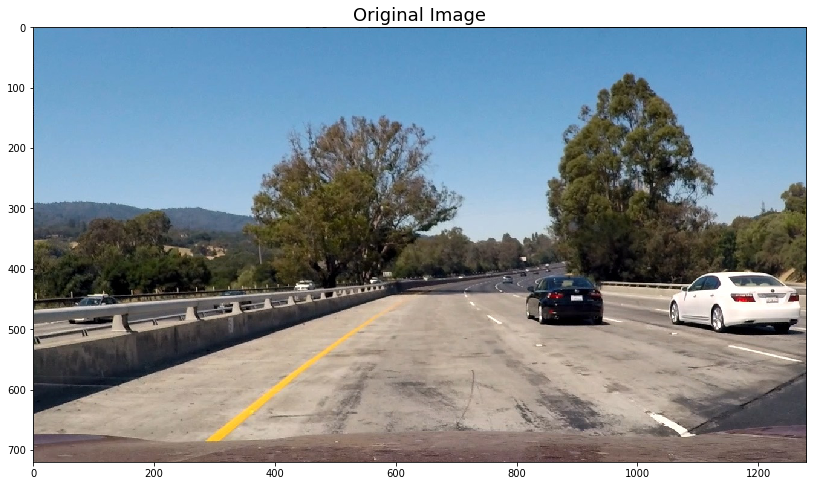

In [4]:
# TODO: Remove absolute path
path = '/Users/chaoyang/udacity/carnd/CarND-Vehicle-Detection/'
test_images = glob.glob(path + 'test_images/test*.jpg')

show(mpimg.imread(test_images[0]), 'Original Image')

In [5]:
# car_image_dirs = [
#     'training/vehicles/GTI_Far/image*.png', 'training/vehicles/GTI_Left/image*.png', 
#     'training/vehicles/GTI_MiddleClose/image*.png', 'training/vehicles/GTI_Right/image*.png',
#     'training/vehicles/KITTI_extracted/*.png'
# ]
# not_car_image_dirs = [
#     'training/non-vehicles/GTI/image*.png', 'training/non-vehicles/Extras/extra*.png'
# ]
# cars = []
# notcars = []

cars = glob.glob(path + 'training/vehicles/**/*.png')
notcars = glob.glob(path + 'training/non-vehicles/**/*.png')

# # Cars images
# cars = glob.glob('C:/AMP/Udacity/vdt_data/vehicles/KITTI_extracted/*.png')

# # Not cars images
# notcars = glob.glob('C:/AMP/Udacity/vdt_data/non-vehicles/Extras/*.png')

# for directory in car_image_dirs:
#     cars.extend(load_data(path + directory))
    
# for directory in not_car_image_dirs:
#     notcars.extend(load_data(path + directory))

print('Training data has ' + str(len(cars)) + ' car images.')
print('Training data has ' + str(len(notcars)) + ' non-car images.')

Training data has 8792 car images.
Training data has 8968 non-car images.


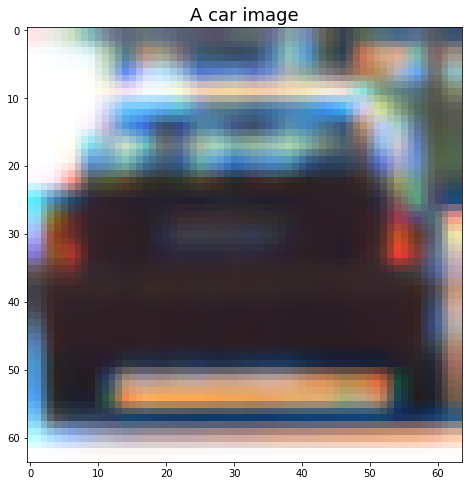

In [6]:
np.random.seed(2017)
rand_ind = np.random.randint(0, len(cars))
show(mpimg.imread(cars[rand_ind]), 'A car image')

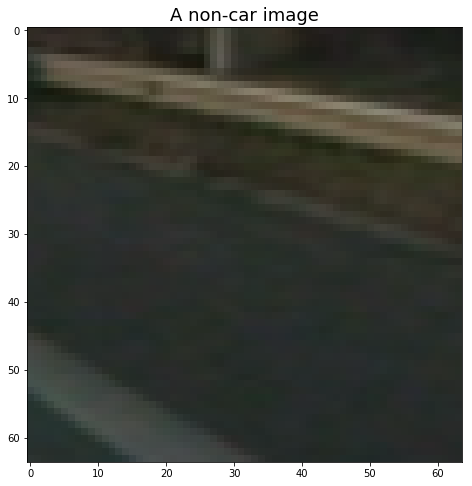

In [7]:
rand_ind = np.random.randint(0, len(notcars))
show(mpimg.imread(notcars[rand_ind]), 'A non-car image')

### Extract features

In [8]:
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=vis, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

hog_features = extract_hog_features(test_images, cspace='YUV', vis=True)

/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


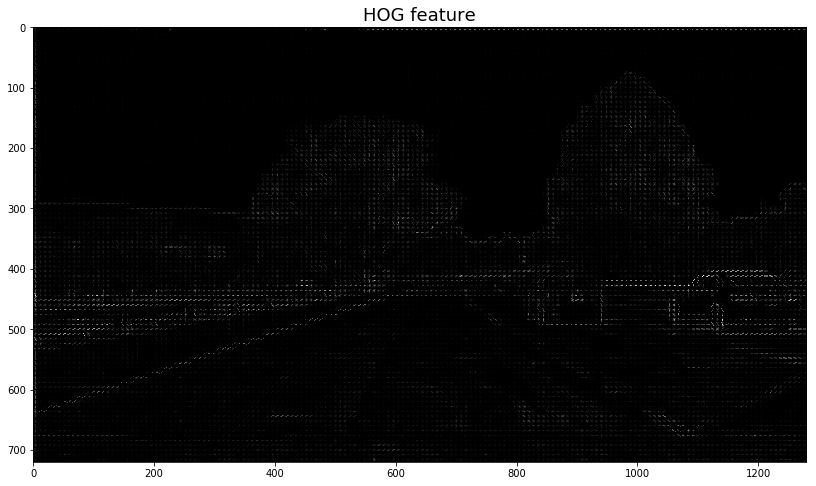

In [9]:
_, hog_img = hog_features[0]

show(hog_img, 'HOG feature', cmap='gray')

/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


/Users/chaoyang/udacity/carnd/CarND-Vehicle-Detection/training/vehicles/GTI_Far/image0000.png


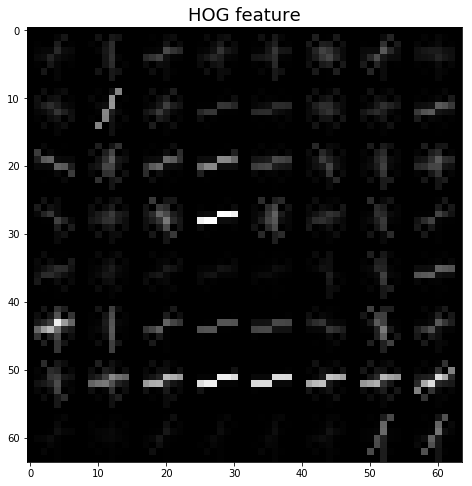

In [10]:
hog_features = extract_hog_features(cars[:1], cspace='YUV', hog_channel=0, vis=True)
_, hog_img = hog_features[0]
print(cars[0])
show(hog_img, 'HOG feature', cmap='gray')

In [11]:
# Compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# Concatenate spacial, hist, hog features
def extract_features(imgs, cspace, orient, pix_per_cell, cell_per_block, hog_channel):
    # Parameters here:
    #     imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False
    #     imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)
    hog_features = extract_hog_features(imgs, cspace, orient, pix_per_cell, cell_per_block, hog_channel)
    color_features = extract_color_features(imgs, cspace)
    print('hog_feature shape: ', hog_features[0].shape)
    print('color_features shape: ', color_features[0].shape)
    print('Full feature shape: ', hog_features[0].shape[0] + color_features[0].shape[0])

    features = []
    for i in range(len(hog_features)):
        features.append(np.concatenate((hog_features[i], color_features[i])))
    return features

### Set parameters

In [12]:
# Feature extraction parameters
CSPACE = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENT = 11
PIX_PER_CELL = 16
CELL_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"

### Train model

In [13]:
car_features = extract_hog_features(cars, CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)
notcar_features = extract_hog_features(notcars, CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)

print('Training data has ' + str(len(car_features)) + ' car features.')
print('Training data has ' + str(len(notcar_features)) + ' non-car features.')

/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Training data has 8792 car features.
Training data has 8968 non-car features.


In [14]:
print(len(car_features[0]))
# print(np.argwhere(np.isnan(car_features)))

1188


In [15]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

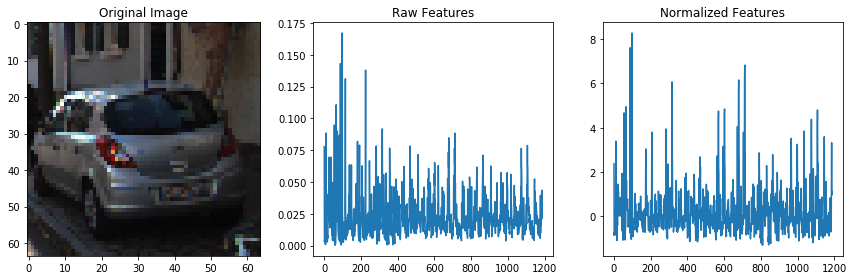

In [16]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))


# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

In [17]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [18]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00153 Seconds to predict 10 labels with SVC


In [19]:
print('My SVC predicts: ', svc.predict(X_test[10:30]))
print('For these',n_predict, 'labels: ', y_test[10:30])

My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  1.]


### Find cars

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL
def find_cars(img, ystart, ystop, scale, svc, cspace, orient, 
              pix_per_cell, cell_per_block, hog_channel, spatial_size=(32, 32), 
              hist_bins=32, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
#     print('img max: ', np.max(img))
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            print('ctrans_tosearch max: ', np.max(ctrans_tosearch))
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
        
#     ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    count = 0
    positive = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            ########################################################
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)
            
# #             print('hog_features.shape: ', hog_features.shape)
# #             print('spatial_features.shape: ', spatial_features.shape)
# #             print('hist_features.shape: ', hist_features.shape)
            
#             X = np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1)
            
#             test_prediction = svc.predict(X)
            ########################################################
            
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('Find car function loaded ...')

Find car function loaded ...


In [21]:
ystart = 400
ystop = 656
scale = 2

print(CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)
test_img = mpimg.imread(test_images[0])
rectangles = find_cars(test_img, ystart, ystop, scale, svc, CSPACE, ORIENT, 
    PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)

print(len(rectangles), 'rectangles found in image')

YUV 11 16 2 ALL
2 rectangles found in image


/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [22]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
print('Find car function loaded ...')

Find car function loaded ...


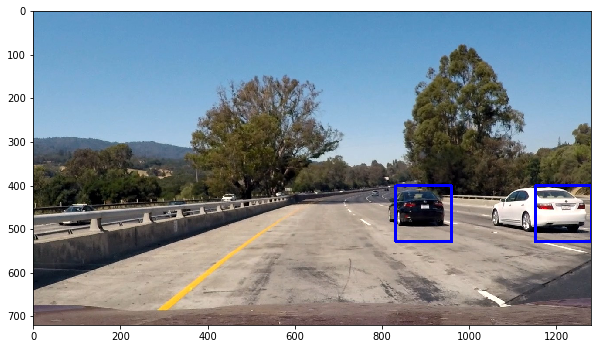

In [23]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


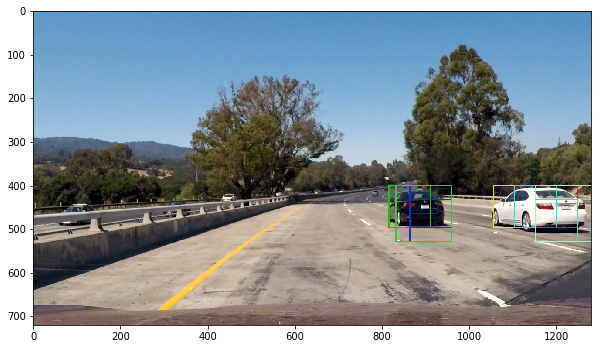

In [24]:
params = [
    (400, 464, 1.0), (416, 480, 1.0), (400, 496, 1.5), (432, 528, 1.5), (400, 528, 2.0), 
    (432, 560, 2.0), (400, 596, 3.5), (464, 660, 3.5)
]

def find_cars_by_params(img, param, svc, cspace, orient, 
              pix_per_cell, cell_per_block, hog_channel):
    return find_cars(img, param[0], param[1], param[2], svc, cspace, orient, 
              pix_per_cell, cell_per_block, hog_channel)

rectangles = []
for param in params:
    rectangles.append(
        find_cars_by_params(test_img, param, svc, CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)
    )


# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

### Heatmap

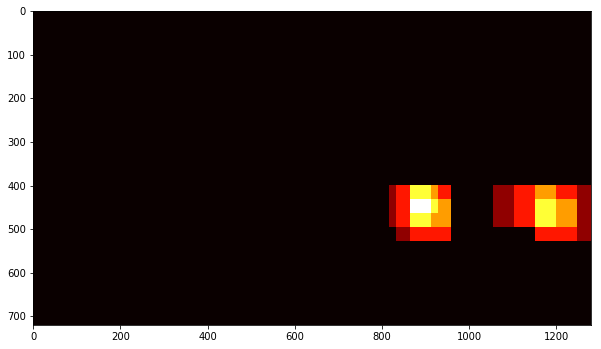

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

In [26]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

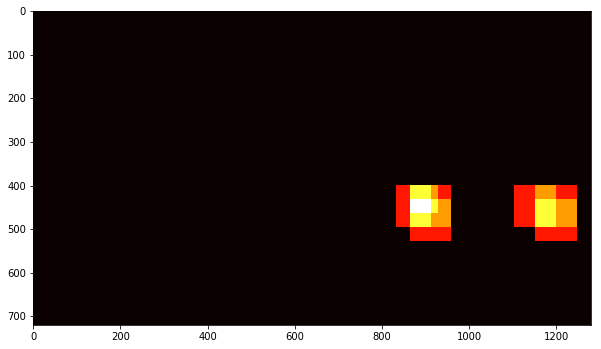

In [27]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

In [28]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

2 cars found


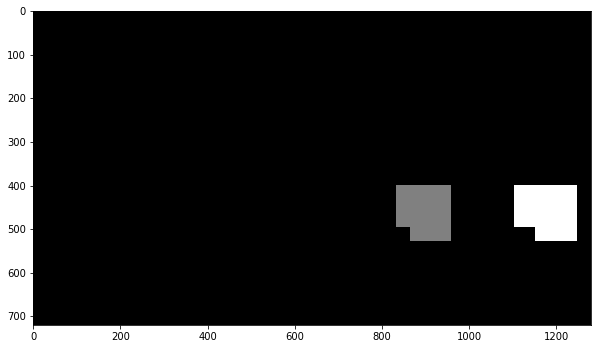

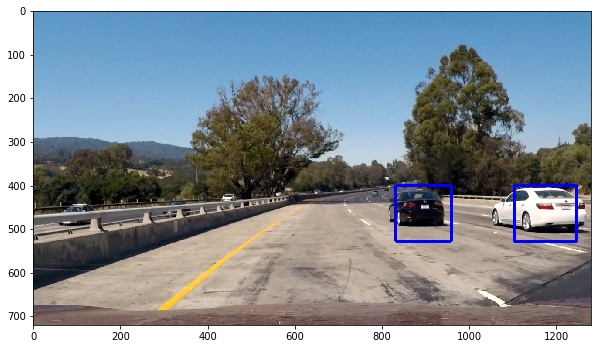

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [30]:
def process(img):

    rectangles = []

    params = [
        (400, 464, 1.0), (416, 480, 1.0), (400, 496, 1.5), (432, 528, 1.5), (400, 528, 2.0), 
        (432, 560, 2.0), (400, 596, 3.5), (464, 660, 3.5)
    ]

    rectangles = []
    for param in params:
        rectangles.append(
            find_cars_by_params(img, param, svc, CSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)
        )


    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 

    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

/usr/local/opt/python/Frameworks/Python.framework/Versions/2.7/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


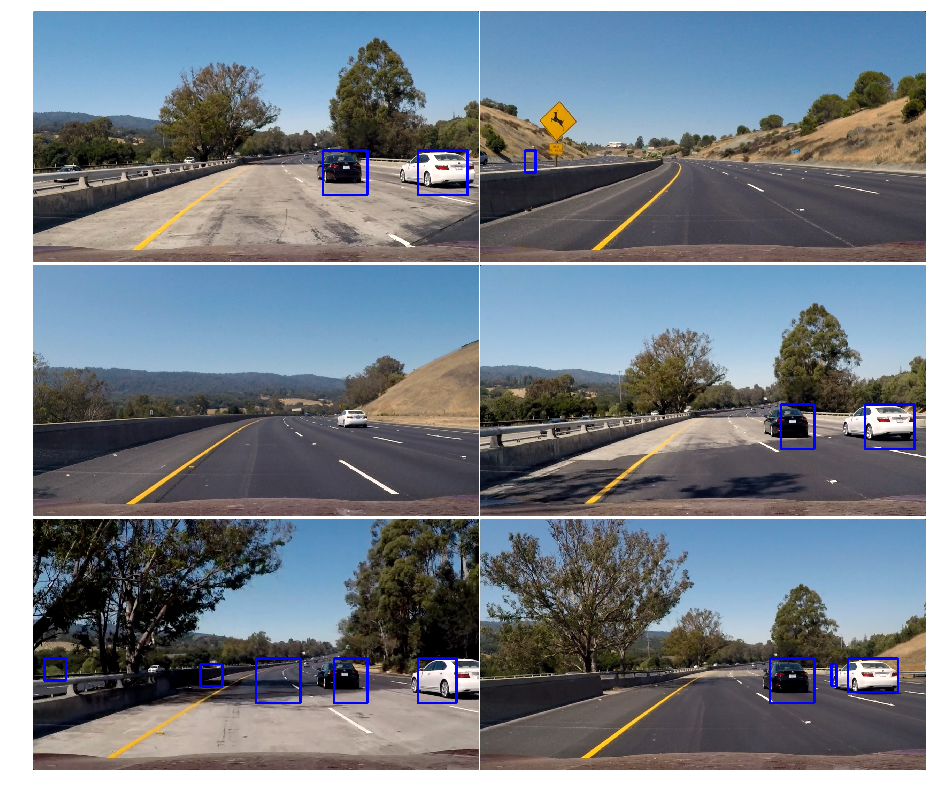

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process(mpimg.imread(im)))
    axs[i].axis('off')
plt.show()

### Video

In [ ]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)